# M-Dwarf

## Direct Imaging vs Coronagraphy

Updates:

  - 04/27/2021 with latest WebbPSF values, updated detector parameters, WFE drift values, and BEX model extrapolations.

In [2]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

pynrc.setup_logging('WARNING', verbose=False)

In [4]:
# Observation Definitions
from pynrc.nb_funcs import make_key, obs_wfe, obs_optimize, model_info

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches
from pynrc.nb_funcs import update_yscale, do_plot_contrasts, do_plot_contrasts2
from pynrc.nb_funcs import plot_hdulist, plot_images, plot_images_swlw

In [5]:
from astropy.table import Table
def make_contrast_tbl(curves):
    
    data = []
    names =[]

    rr = curves[0][0]
    igood = rr>1.5
    data.append(rr[igood])
    names.append('Arcsec')

    for j, vals in enumerate(curves):
        rr, contrast, sen = vals

        data.append(contrast[igood])
        data.append(sen[igood])

        wfe = wfe_list[j]
        names.append('Contr_{:.0f}nm'.format(wfe))
        names.append('Sen_{:.0f}nm'.format(wfe))

    # Modify number formats
    tbl = Table(data, names=names)
    tbl[names[0]].format = '.4f'
    for name in names:
        if  'Cont' in name: fmt = '.3E'
        elif 'Sen' in name: fmt ='.4f'
        else: fmt = tbl[name].format

        tbl[name].format = fmt
        
    return tbl

In [6]:
def update_yscale2(ax, scale_type, ylim=None):
    
    # Some fancy log+linear plotting
    from matplotlib.ticker import FixedLocator, ScalarFormatter, LogFormatterSciNotation
    if scale_type=='symlog':
        ylim = [0,100] if ylim is None else ylim
        ax.set_ylim(ylim)
        yr = ax.get_ylim()
        ax.set_yscale('symlog', linthreshy=10, linscaley=2)
        ax.set_yticks(list(range(0,10)) + [10,100,1000])
        #ax.get_yaxis().set_major_formatter(ScalarFormatter())
        ax.yaxis.set_major_formatter(ScalarFormatter())

        minor_log = list(np.arange(20,100,10)) + list(np.arange(200,1000,100))
        minorLocator = FixedLocator(minor_log)
        ax.yaxis.set_minor_locator(minorLocator)
        ax.set_ylim([0,yr[1]])
    elif scale_type=='log':
        ax.set_yscale('log')
        ylim = [0.1,100] if ylim is None else ylim
        ax.set_ylim(ylim)
        ax.yaxis.set_major_formatter(LogFormatterSciNotation())

## Define Sources and their Reference PSF Stars

In [7]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [8]:
# Argument list:(Name,           dist, age, sptype,  mag)
args_sources = [('AUMic',         9.72,  24,  'M1V',  4.53, bp_k),
                ('HIP17695',     16.80, 150,  'M3V',  6.93, bp_k),
                ('G7-34',        14.59, 150,  'M4V',  8.18, bp_k),
                ('TYC5899',      15.83, 130,  'M3V',  6.89, bp_k),
                
                ('2MJ0944-1220', 13.13,  50,  'M5V',  7.60, bp_k),
                ('APCol',         8.67,  50,  'M5V',  6.87, bp_k),
                ('FomalhautC',    7.67, 440,  'M4V',  7.21, bp_k),
                
                ('LP944-20',      6.42, 200,  'M9V',  9.55, bp_k),
                ('2MJ0443+0002', 21.09,  24,  'M9V', 11.22, bp_k)]

ref_sources  = [('TYC5899',      'M3V',  6.9, bp_k),
                ('TYC5899',      'M3V',  6.9, bp_k),
                ('TYC5899',      'M3V',  6.9, bp_k),
                ('HIP17695',     'M3V',  6.9, bp_k),
                ('APCol',        'M5V',  6.9, bp_k),
                ('2MJ0944-1220', 'M5V',  7.6, bp_k),
                ('APCol',        'M5V',  6.9, bp_k),
                ('2MJ0443+0002', 'M9V', 11.2, bp_k),
                ('LP944-20',     'M9V',  9.6, bp_k)]


In [9]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'MDwarfs/'

In [10]:
# List of filters
args_filter = [('F480M', None, None),
#               ('F444W', None, None),
               ('F444W', 'CIRCLYOT', 'MASK430R')]

subsize = 320

filt_keys = []
for filt,pupil,mask in args_filter:
    filt_keys.append(make_key(filt, pupil=pupil, mask=mask)) 

## AU Mic

In [11]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=True, robust=True, wlim=[1,10])

# Final source spectrum
sp_sci = src.sp_model

[0.96383961]


In [12]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True, wlim=[1,10])

# Final reference spectrum
sp_ref = ref.sp_model

[1.00340101]


In [13]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F480M_none_none
F444W_MASK430R_CIRCLYOT


In [14]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,600,600)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,17,17)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(key)
    print(obs.multiaccum_times)
    _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    print('')

F480M_none_none
{'t_frame': 0.27864, 't_group': 0.27864, 't_int': 2.7864, 't_exp': 1671.84, 't_acq': 1842.12, 't_int_tot1': 3.0702, 't_int_tot2': 3.0702}
Point Source Sensitivity (5-sigma): 20.98 vegamag
Surface Brightness Sensitivity (5-sigma): 19.09 vegamag/arcsec^2

F444W_MASK430R_CIRCLYOT
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 1781.02064, 't_acq': 1799.53296, 't_int_tot1': 105.85488, 't_int_tot2': 105.85488}
Point Source Sensitivity (5-sigma): 21.49 vegamag
Surface Brightness Sensitivity (5-sigma): 22.82 vegamag/arcsec^2



In [15]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F480M_none_none
Sci: AUMic
  24 saturated pixel at NGROUP=2; Max Well: 21.52
  95 saturated pixel at NGROUP=10; Max Well: 107.58
  Sat Dist NG=2: 0.28 arcsec
Ref: TYC5899
  9 saturated pixel at NGROUP=2; Max Well: 2.46
  21 saturated pixel at NGROUP=10; Max Well: 12.28

F444W_MASK430R_CIRCLYOT
Sci: AUMic
  0 saturated pixel at NGROUP=2; Max Well: 0.07
  0 saturated pixel at NGROUP=10; Max Well: 0.39
  Sat Dist NG=2: 0.00 arcsec
Ref: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.04


In [16]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,1,2,5]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

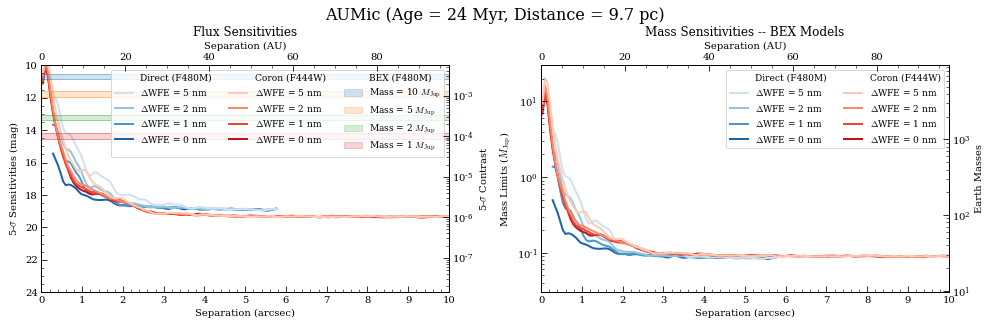

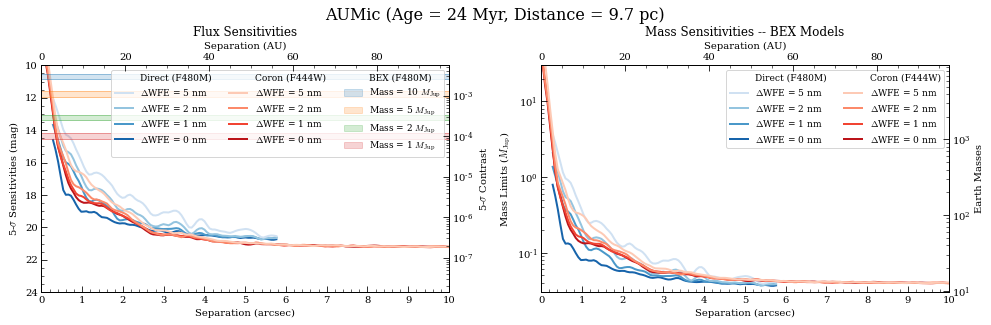

In [18]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
key1, key2 = ('F480M_none_none', 'F444W_MASK430R_CIRCLYOT')
for curves in [curves_ref, curves_roll]:
    #key1 = filt_keys[0]
    #key2 = filt_keys[1]
    lab1 = 'Direct (F480M)'
    lab2 = 'Coron (F444W)'
    fig, axes_all = do_plot_contrasts2(key1, key2, curves, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 30], linder_models=True)

    fname = "{}_compare.pdf".format(name_sci.replace(" ", ""))
    fig.savefig(outdir+fname)

## HIP 17695

In [19]:
# Fit spectrum to SED photometry
i=1
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,10])

# Final source spectrum
sp_sci = src.sp_model

[0.9587122]


In [20]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True, wlim=[1,10])

# Final reference spectrum
sp_ref = ref.sp_model

[1.00340101]


In [21]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F480M_none_none
F444W_MASK430R_CIRCLYOT


In [22]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,600,600)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,17,17)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')

In [23]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F480M_none_none
Sci: HIP17695
  9 saturated pixel at NGROUP=2; Max Well: 2.28
  21 saturated pixel at NGROUP=10; Max Well: 11.41
  Sat Dist NG=2: 0.09 arcsec
Ref: TYC5899
  9 saturated pixel at NGROUP=2; Max Well: 2.46
  21 saturated pixel at NGROUP=10; Max Well: 12.28

F444W_MASK430R_CIRCLYOT
Sci: HIP17695
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.04
  Sat Dist NG=2: 0.00 arcsec
Ref: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.04


In [25]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,1,2,5]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

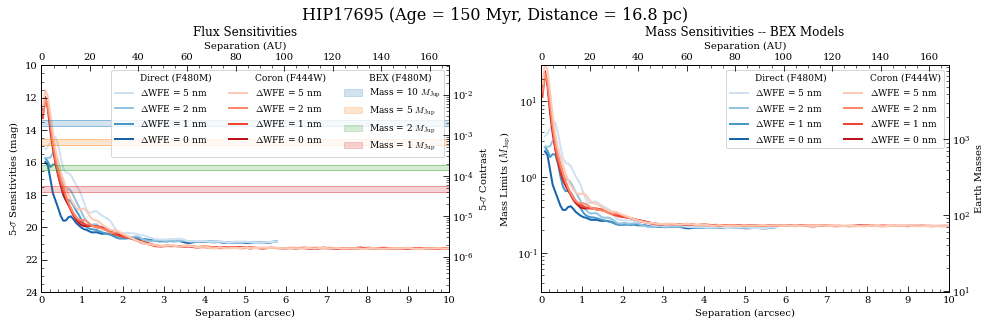

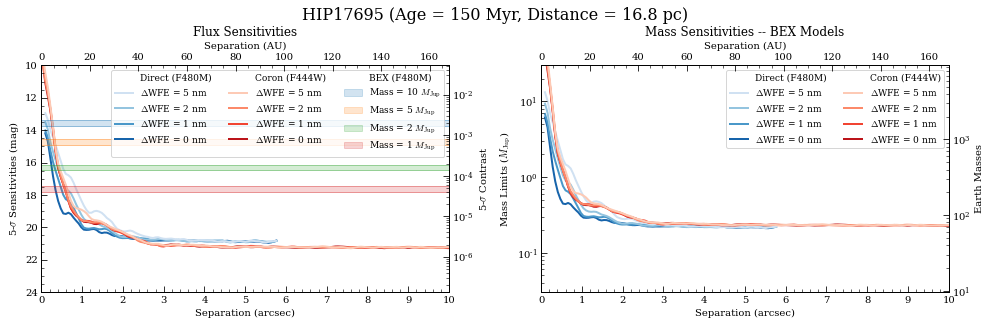

In [26]:
key1, key2 = ('F480M_none_none', 'F444W_MASK430R_CIRCLYOT')
for curves in [curves_ref, curves_roll]:
    lab1 = 'Direct (F480M)'
    lab2 = 'Coron (F444W)'
    fig, axes_all = do_plot_contrasts2(key1, key2, curves, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 30], linder_models=True)

    fname = "{}_compare.pdf".format(name_sci.replace(" ", ""))
    fig.savefig(outdir+fname)

## G 7-34

In [27]:
# Fit spectrum to SED photometry
i=2
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,10])

# Final source spectrum
sp_sci = src.sp_model

[0.95662904]


In [28]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True, wlim=[1,10])

# Final reference spectrum
sp_ref = ref.sp_model

[1.00340101]


In [29]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F480M_none_none
F444W_MASK430R_CIRCLYOT


In [30]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,600,600)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,17,17)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')

In [31]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F480M_none_none
Sci: G7-34
  0 saturated pixel at NGROUP=2; Max Well: 0.72
  9 saturated pixel at NGROUP=10; Max Well: 3.58
  Sat Dist NG=2: 0.09 arcsec
Ref: TYC5899
  9 saturated pixel at NGROUP=2; Max Well: 2.46
  21 saturated pixel at NGROUP=10; Max Well: 12.28

F444W_MASK430R_CIRCLYOT
Sci: G7-34
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.01
  Sat Dist NG=2: 0.00 arcsec
Ref: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.04


In [32]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,1,2,5]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

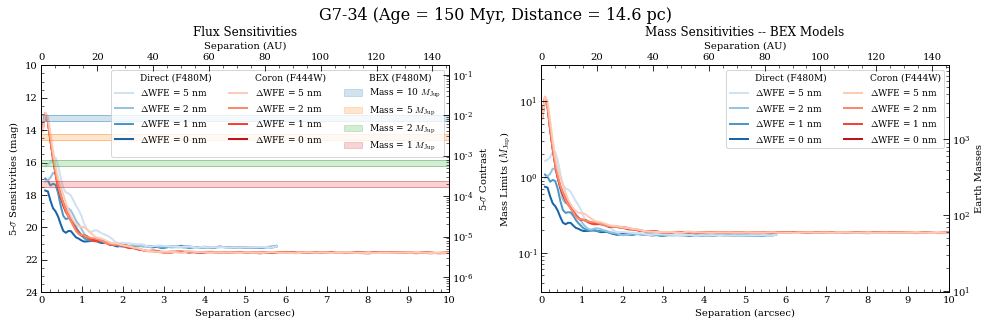

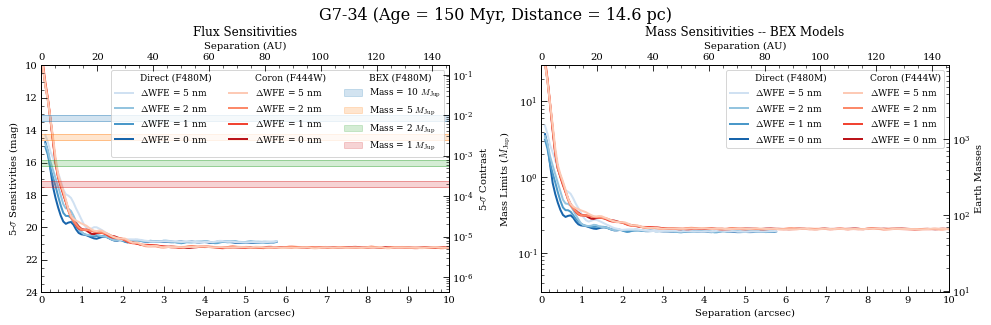

In [33]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
key1, key2 = ('F480M_none_none', 'F444W_MASK430R_CIRCLYOT')
for curves in [curves_ref, curves_roll]:
    #key1 = filt_keys[0]
    #key2 = filt_keys[1]
    lab1 = 'Direct (F480M)'
    lab2 = 'Coron (F444W)'
    fig, axes_all = do_plot_contrasts2(key1, key2, curves, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 30], linder_models=True)

    fname = "{}_compare.pdf".format(name_sci.replace(" ", ""))
    fig.savefig(outdir+fname)

## TYC5899

In [34]:
# Fit spectrum to SED photometry
i=3
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[0.96663111]


In [35]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True, wlim=[1,5])

# Final reference spectrum
sp_ref = ref.sp_model

[0.93386822]


In [36]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F480M_none_none
F444W_MASK430R_CIRCLYOT


In [37]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,600,600)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,17,17)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')

In [38]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F480M_none_none
Sci: TYC5899
  9 saturated pixel at NGROUP=2; Max Well: 2.39
  21 saturated pixel at NGROUP=10; Max Well: 11.94
  Sat Dist NG=2: 0.09 arcsec
Ref: HIP17695
  9 saturated pixel at NGROUP=2; Max Well: 2.29
  21 saturated pixel at NGROUP=10; Max Well: 11.43

F444W_MASK430R_CIRCLYOT
Sci: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.04
  Sat Dist NG=2: 0.00 arcsec
Ref: HIP17695
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.04


In [39]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,1,2,5]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

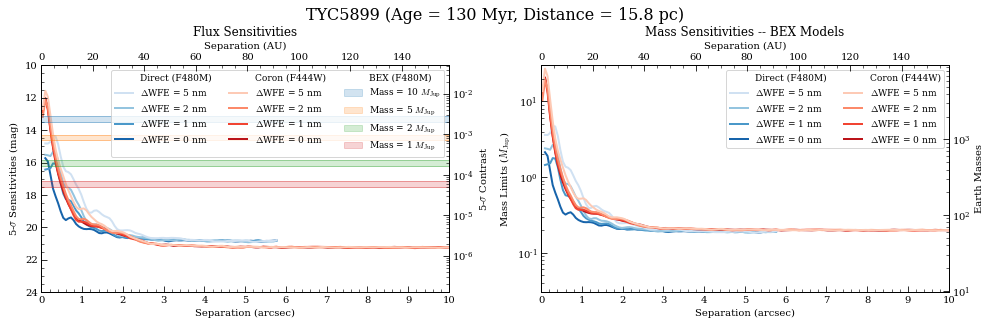

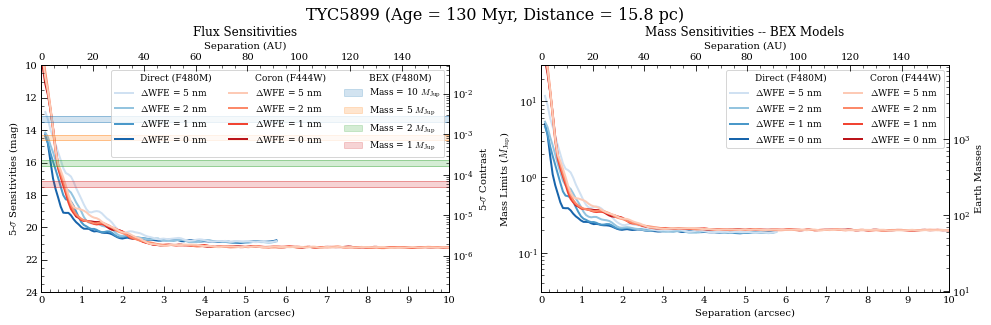

In [40]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
key1, key2 = ('F480M_none_none', 'F444W_MASK430R_CIRCLYOT')
for curves in [curves_ref, curves_roll]:
    lab1 = 'Direct (F480M)'
    lab2 = 'Coron (F444W)'
    fig, axes_all = do_plot_contrasts2(key1, key2, curves, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 30], linder_models=True)

    fname = "{}_compare.pdf".format(name_sci.replace(" ", ""))
    fig.savefig(outdir+fname)

## 2MJ0944

In [41]:
# Fit spectrum to SED photometry
i=4
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final source spectrum
sp_sci = src.sp_model

[0.99289929]


In [43]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True, wlim=[1,10])

# Final reference spectrum
sp_ref = ref.sp_model

[1.38783114]


In [44]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F480M_none_none
F444W_MASK430R_CIRCLYOT


In [45]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,600,600)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,17,17)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')

In [46]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F480M_none_none
Sci: 2MJ0944-1220
  2 saturated pixel at NGROUP=2; Max Well: 1.30
  13 saturated pixel at NGROUP=10; Max Well: 6.52
  Sat Dist NG=2: 0.09 arcsec
Ref: APCol
  9 saturated pixel at NGROUP=2; Max Well: 3.48
  21 saturated pixel at NGROUP=10; Max Well: 17.38

F444W_MASK430R_CIRCLYOT
Sci: 2MJ0944-1220
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.02
  Sat Dist NG=2: 0.00 arcsec
Ref: APCol
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06


In [47]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,1,2,5]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

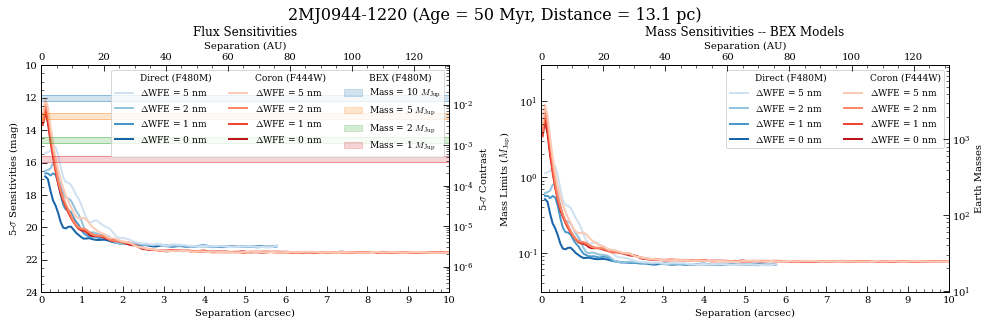

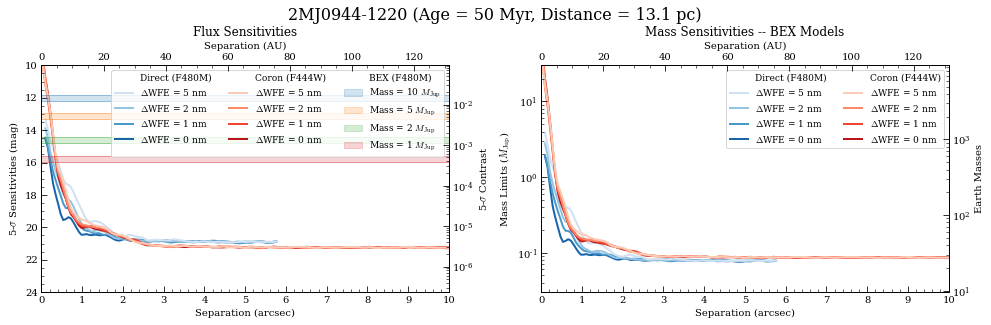

In [48]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
key1, key2 = ('F480M_none_none', 'F444W_MASK430R_CIRCLYOT')
for curves in [curves_ref, curves_roll]:
    #key1 = filt_keys[0]
    #key2 = filt_keys[1]
    lab1 = 'Direct (F480M)'
    lab2 = 'Coron (F444W)'
    fig, axes_all = do_plot_contrasts2(key1, key2, curves, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 30], linder_models=True)

    fname = "{}_compare.pdf".format(name_sci.replace(" ", ""))
    fig.savefig(outdir+fname)

## AP Col

In [49]:
# Fit spectrum to SED photometry
i=5
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final source spectrum
sp_sci = src.sp_model

[0.99615671]


In [50]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True, wlim=[2,5])

# Final reference spectrum
sp_ref = ref.sp_model

[0.97577795]


In [51]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F480M_none_none
F444W_MASK430R_CIRCLYOT


In [52]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,600,600)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,17,17)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')

In [53]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F480M_none_none
Sci: APCol
  9 saturated pixel at NGROUP=2; Max Well: 2.56
  21 saturated pixel at NGROUP=10; Max Well: 12.82
  Sat Dist NG=2: 0.09 arcsec
Ref: 2MJ0944-1220
  1 saturated pixel at NGROUP=2; Max Well: 1.28
  13 saturated pixel at NGROUP=10; Max Well: 6.41

F444W_MASK430R_CIRCLYOT
Sci: APCol
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.05
  Sat Dist NG=2: 0.00 arcsec
Ref: 2MJ0944-1220
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.02


In [54]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,1,2,5]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

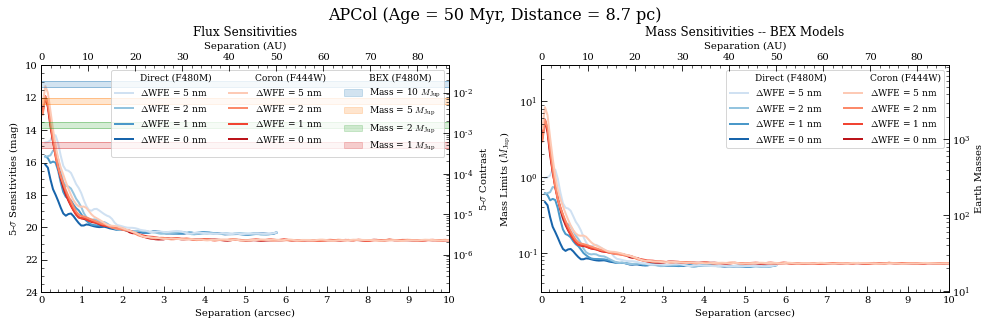

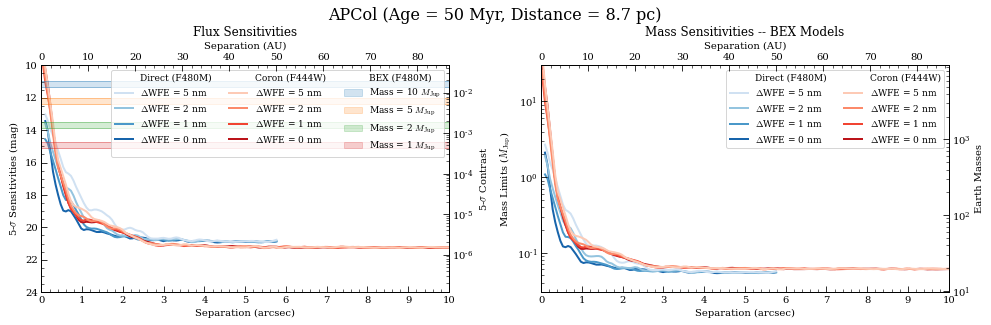

In [55]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
key1, key2 = ('F480M_none_none', 'F444W_MASK430R_CIRCLYOT')
for curves in [curves_ref, curves_roll]:
    #key1 = filt_keys[0]
    #key2 = filt_keys[1]
    lab1 = 'Direct (F480M)'
    lab2 = 'Coron (F444W)'
    fig, axes_all = do_plot_contrasts2(key1, key2, curves, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 30], linder_models=True)

    fname = "{}_compare.pdf".format(name_sci.replace(" ", ""))
    fig.savefig(outdir+fname)

## Fomalhaut C

In [56]:
# Fit spectrum to SED photometry
i=6
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final source spectrum
sp_sci = src.sp_model

[0.99989308]


In [62]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=True, wlim=[2,10])

# Final reference spectrum
sp_ref = ref.sp_model

[1.02407614]


In [63]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F480M_none_none
F444W_MASK430R_CIRCLYOT


In [64]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,600,600)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,17,17)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')

In [65]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F480M_none_none
Sci: FomalhautC
  5 saturated pixel at NGROUP=2; Max Well: 1.83
  21 saturated pixel at NGROUP=10; Max Well: 9.15
  Sat Dist NG=2: 0.09 arcsec
Ref: APCol
  9 saturated pixel at NGROUP=2; Max Well: 2.56
  21 saturated pixel at NGROUP=10; Max Well: 12.82

F444W_MASK430R_CIRCLYOT
Sci: FomalhautC
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.03
  Sat Dist NG=2: 0.00 arcsec
Ref: APCol
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.05


In [66]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,1,2,5]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

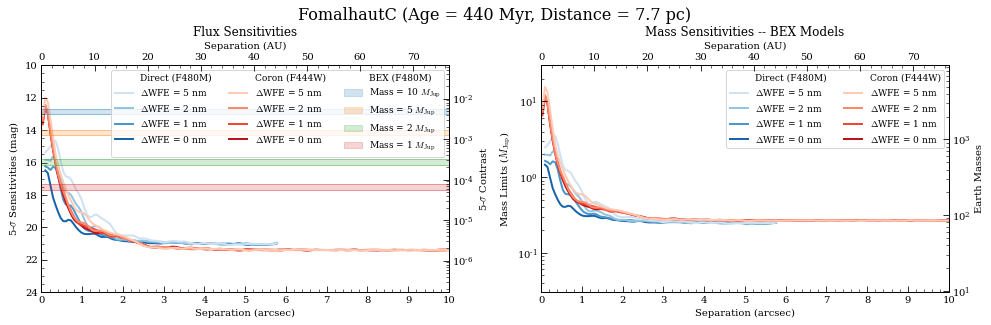

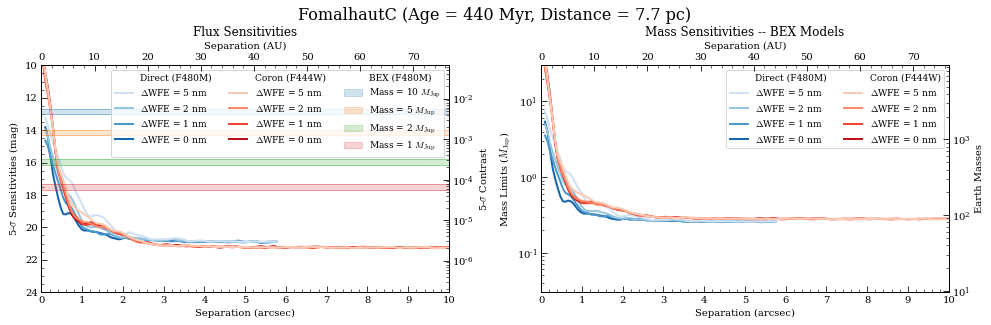

In [67]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
key1, key2 = ('F480M_none_none', 'F444W_MASK430R_CIRCLYOT')
for curves in [curves_ref, curves_roll]:
    #key1 = filt_keys[0]
    #key2 = filt_keys[1]
    lab1 = 'Direct (F480M)'
    lab2 = 'Coron (F444W)'
    fig, axes_all = do_plot_contrasts2(key1, key2, curves, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 30], linder_models=True)

    fname = "{}_compare.pdf".format(name_sci.replace(" ", ""))
    fig.savefig(outdir+fname)

## LP 944-20

In [85]:
# Fit spectrum to SED photometry
i=7
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final source spectrum
sp_sci = src.sp_model

[1.00271333]


In [86]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final reference spectrum
sp_ref = ref.sp_model

[0.98601853]


In [87]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F480M_none_none
F444W_MASK430R_CIRCLYOT


In [88]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,100,100)
        obs.update_detectors(xpix=400, ypix=400)
        obs.nrc_ref.update_detectors(xpix=400, ypix=400)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,17,17)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(key)
    print(obs.multiaccum_times)
    _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    print('')

F480M_none_none
{'t_frame': 1.65624, 't_group': 1.65624, 't_int': 16.5624, 't_exp': 1656.24, 't_acq': 1823.924, 't_int_tot1': 18.23924, 't_int_tot2': 18.23924}
Point Source Sensitivity (5-sigma): 21.89 vegamag
Surface Brightness Sensitivity (5-sigma): 19.99 vegamag/arcsec^2

F444W_MASK430R_CIRCLYOT
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 1781.02064, 't_acq': 1799.53296, 't_int_tot1': 105.85488, 't_int_tot2': 105.85488}
Point Source Sensitivity (5-sigma): 21.49 vegamag
Surface Brightness Sensitivity (5-sigma): 22.82 vegamag/arcsec^2



In [89]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F480M_none_none
Sci: LP944-20
  1 saturated pixel at NGROUP=2; Max Well: 1.30
  13 saturated pixel at NGROUP=10; Max Well: 6.52
  Sat Dist NG=2: 0.00 arcsec
Ref: 2MJ0443+0002
  0 saturated pixel at NGROUP=2; Max Well: 0.28
  5 saturated pixel at NGROUP=10; Max Well: 1.40

F444W_MASK430R_CIRCLYOT
Sci: LP944-20
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.00
  Sat Dist NG=2: 0.00 arcsec
Ref: 2MJ0443+0002
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.00


In [90]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,1,2,5]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

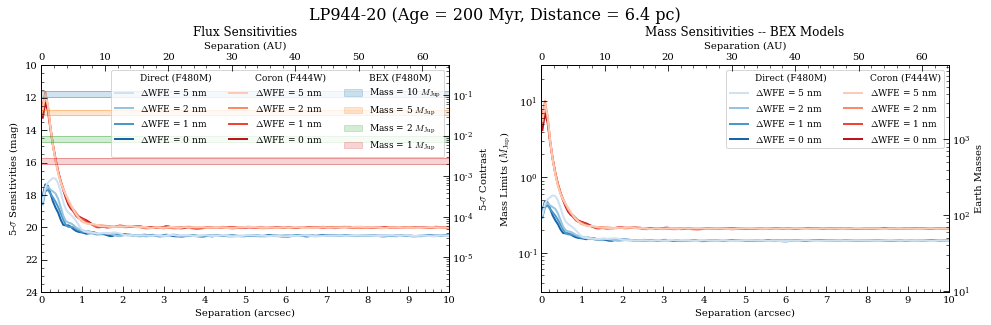

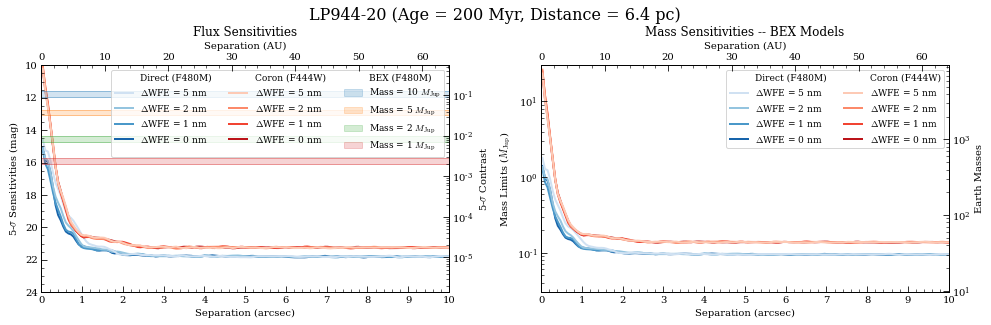

In [91]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
key1, key2 = ('F480M_none_none', 'F444W_MASK430R_CIRCLYOT')
for curves in [curves_ref, curves_roll]:
    lab1 = 'Direct (F480M)'
    lab2 = 'Coron (F444W)'
    fig, axes_all = do_plot_contrasts2(key1, key2, curves, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 30], linder_models=True)

    fname = "{}_compare.pdf".format(name_sci.replace(" ", ""))
    fig.savefig(outdir+fname)

## 2MJ0443

In [76]:
# Fit spectrum to SED photometry
i=8
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[2,10])

# Final source spectrum
sp_sci = src.sp_model

[1.00434998]


In [78]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=True, wlim=[2,10])

# Final reference spectrum
sp_ref = ref.sp_model

[1.04996976]


In [79]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F480M_none_none
F444W_MASK430R_CIRCLYOT


In [81]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,100,100)
        obs.update_detectors(xpix=400, ypix=400)
        obs.nrc_ref.update_detectors(xpix=400, ypix=400)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,17,17)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(key)
    print(obs.multiaccum_times)
    _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    print('')

F480M_none_none
{'t_frame': 1.65624, 't_group': 1.65624, 't_int': 16.5624, 't_exp': 1656.24, 't_acq': 1823.924, 't_int_tot1': 18.23924, 't_int_tot2': 18.23924}
Point Source Sensitivity (5-sigma): 21.89 vegamag
Surface Brightness Sensitivity (5-sigma): 19.99 vegamag/arcsec^2

F444W_MASK430R_CIRCLYOT
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 1781.02064, 't_acq': 1799.53296, 't_int_tot1': 105.85488, 't_int_tot2': 105.85488}
Point Source Sensitivity (5-sigma): 21.49 vegamag
Surface Brightness Sensitivity (5-sigma): 22.82 vegamag/arcsec^2



In [82]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F480M_none_none
Sci: 2MJ0443+0002
  0 saturated pixel at NGROUP=2; Max Well: 0.28
  5 saturated pixel at NGROUP=10; Max Well: 1.40
  Sat Dist NG=2: 0.00 arcsec
Ref: LP944-20
  1 saturated pixel at NGROUP=2; Max Well: 1.30
  13 saturated pixel at NGROUP=10; Max Well: 6.52

F444W_MASK430R_CIRCLYOT
Sci: 2MJ0443+0002
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.00
  Sat Dist NG=2: 0.00 arcsec
Ref: LP944-20
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.00


In [83]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,1,2,5]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/4 [00:00<?, ?it/s]

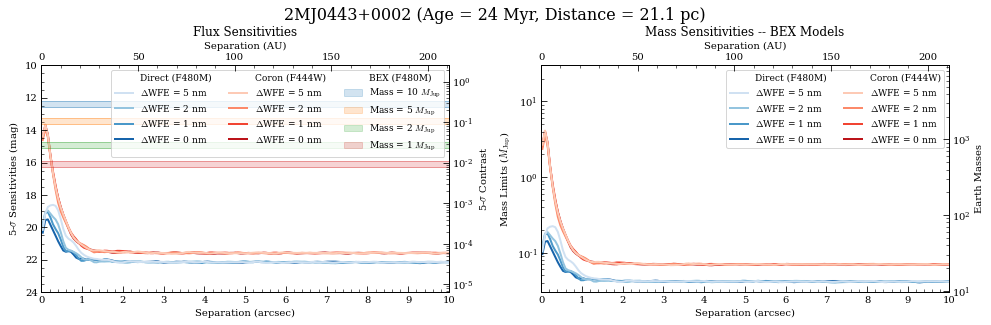

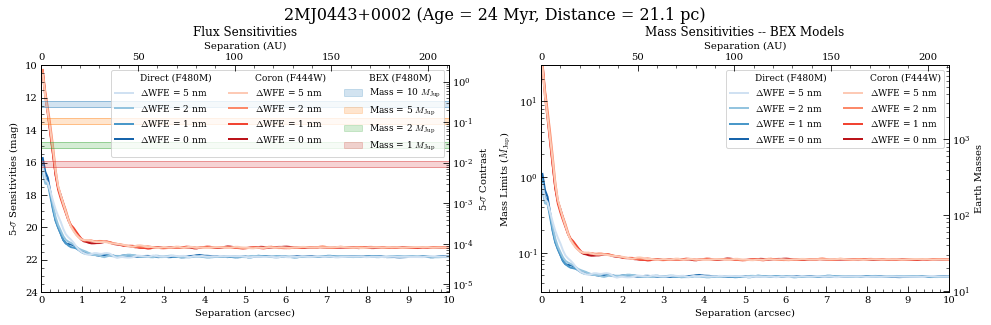

In [84]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
key1, key2 = ('F480M_none_none', 'F444W_MASK430R_CIRCLYOT')
for curves in [curves_ref, curves_roll]:
    lab1 = 'Direct (F480M)'
    lab2 = 'Coron (F444W)'
    fig, axes_all = do_plot_contrasts2(key1, key2, curves, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 30], linder_models=True)

    fname = "{}_compare.pdf".format(name_sci.replace(" ", ""))
    fig.savefig(outdir+fname)